# **Práctica 3: Brillo y contraste**

<img src ="https://epigijon.uniovi.es/image/image_gallery?uuid=903ae5c8-b29b-430e-980d-1a19a885c736&groupId=3743853&t=1688576582973" width=300px>

Este cuaderno desarrolla contenidos prácticos de la asignatura **Visión artificial** del Grado en Ciencia e Ingeniería de Datos.

***

# Histograma

Para analizar el brillo y el contraste de una imagen es importante entender el histograma de intensidades. Para ello se va a comenzar la práctica realizando una función para visualizar una imagen junto a su histograma.


> Implementa una función que dada una imagen realice una visualización conjunta tanto de la imagen como de su histograma y distribución acumulada siguiendo las indicaciones que se muestran a continuación:
>
> Se debe verificar que la imagen es de tipo uint8. El histograma tendrá 256 intervalos (bins), desde 0 a 255
>
> La función debe permitir el uso de imágenes en color o de imágenes en escala de grises
>
> Para calcular el histograma se debe implementar una función propia
>

A continuación se muestra algo de ayuda.



-Nota: El mayor valor que puede tener el histograma depende del número total de píxeles en la imagen, ya que el histograma cuenta cuántas veces aparece un valor específico de intensidad (de 0 a 255 en una imagen en escala de grises de 8 bits). El valor más alto del histograma será el que corresponda al nivel de intensidad con más frecuencia en la imagen, y este valor puede ser tan grande como el tamaño total de la imagen.

-Nota: El histograma de una imagen en escala de grises, cuando se trabaja con un rango de 8 bits por píxel, tiene 256 posibles valores de intensidad (de 0 a 255). Por lo tanto, el tamaño del array utilizado para almacenar el histograma de una imagen en escala de grises es de 256 elementos, donde cada elemento corresponde a la frecuencia de aparición de cada valor de intensidad.

RGB: El histograma se almacena en tres arrays (uno para cada canal), cada uno de tamaño 256. En total, para almacenar los histogramas de todos los canales RGB, se necesitarán tres arrays de tamaño 256.

In [2]:
# Importar bibliotecas que pueden ser necesarias
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import skimage 

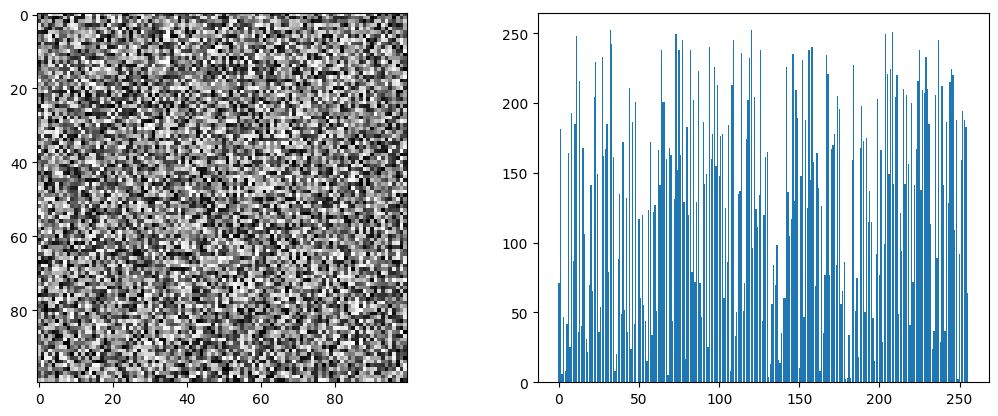

In [3]:
# Creación de la figura
width, height = plt.rcParams['figure.figsize']
fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(2*width, height))

# La primera se usará para la imagen, la segunda para el histograma

# Ejemplo de visualización de la imagen
img = np.random.randint(0, 256, size=(100, 100), dtype=np.uint8)
ax_img.imshow(img, cmap='gray')

# Ejemplo de visualización del histograma
hist = np.random.randint(0, 256, size=(256,), dtype=np.uint8)
ax_hist.bar(np.arange(256), hist)
plt.show()

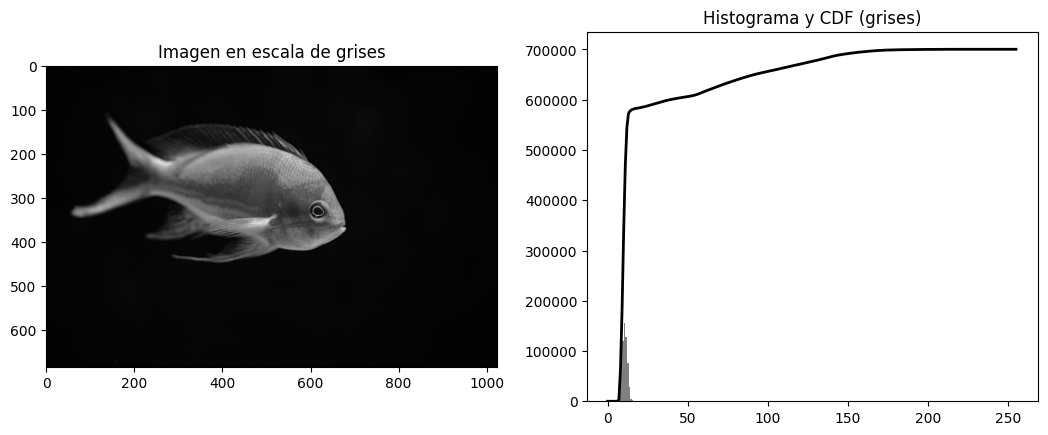

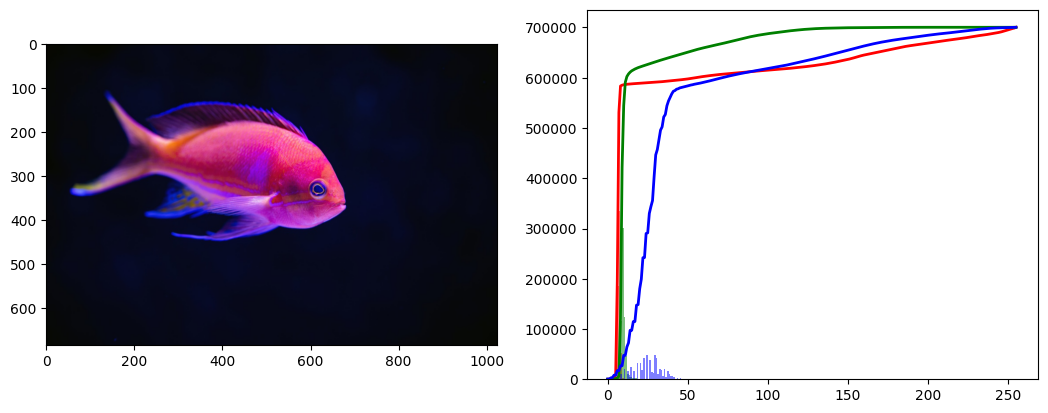

In [ ]:
def iter_channels(color_image):
    # Esta función sirve SOLO para imágenes en color (alto, ancho, 3)
    # np.rollaxis(color_image, -1) mueve el eje de canales (último eje) al principio,
    # para poder iterar canal por canal: primero R, luego G, luego B (si la imagen está en RGB).
    for channel in np.rollaxis(color_image, -1):
        # yield devuelve un canal cada vez (generador), sin crear una lista completa
        # Cada 'channel' es una imagen 2D (alto, ancho) de intensidades 0-255 para ese canal específico.
        yield channel

def calculate_histogram(img):
    # COMPROBACIÓN DEL ENUNCIADO: la imagen debe ser uint8 (valores 0..255)
    if img.dtype != np.uint8:
        raise ValueError("La imagen debe ser de tipo uint8.")
    hist=np.zeros(256) # Creamos el histograma: 256 posiciones (bins) para intensidades 0..255. Al inicio todas las frecuencias son 0
    # Recorremos todos los píxeles de la imagen 2D
    for i in range(len(img)): # recorre filas (0..alto-1)
        for j in range(len(img[i])): # recorre columnas (0..ancho-1)
            # img[i, j] es la intensidad del píxel (un número entre 0 y 255)
            # sumamos 1 en el bin correspondiente a esa intensidad
            hist[img[i,j]]+=1 # “He encontrado un píxel más con intensidad img[i, j], así que incremento el contador de esa intensidad en 1”. 
    # Devuelve un array de tamaño 256:
    # hist[k] = número de píxeles que tienen intensidad k
    return hist

#def calculate_cdf(hist):
#    return np.cumsum(hist)

def calculate_cdf(hist):
    # Queremos calcular el histograma acumulado (CDF):
    # H[k] = sum_{i=0..k} h[i]
    # Es decir, vamos acumulando desde 0 hasta cada k.

    # Creamos un array del mismo tamaño que hist (256) para almacenar el CDF
    cdf = np.zeros(len(hist))
    # Caso base: el acumulado en 0 es simplemente el histograma en 0
    cdf[0] = hist[0]
    # Para cada nivel de intensidad k, acumulamos lo anterior + lo actual
    # cdf[k] = cdf[k-1] + hist[k]
    for k in range(1, len(hist)):
        cdf[k] = cdf[k-1] + hist[k]
    return cdf

# Función para visualizar el histograma de una imagen
def plot_histogram(ax,img):
    # 'ax' es el eje donde vamos a dibujar (el subplot del histograma)
    # 'img' puede ser:
    # - 2D (grises)
    # - 3D (color: alto, ancho, canales)

    if img.ndim == 2:
        # ---- CASO 1: IMAGEN EN ESCALA DE GRISES ----

        # Calculamos el histograma con nuestra función propia
        hist = calculate_histogram(img)

        # Dibujamos el histograma:
        # - np.arange(256) son los niveles 0..255
        # - weights=hist indica cuántas veces aparece cada nivel
        ax.hist(np.arange(256), bins=256, weights=hist.flatten(),
                color='gray', range=(0, 256))

        # Calculamos el acumulado (CDF) con la función implementada "a mano"
        cdf = calculate_cdf(hist)

        # Dibujamos la CDF como una línea encima del histograma
        ax.plot(np.arange(256), cdf, color='black', linewidth=2)

        pass  # (Este pass no hace falta, pero no estorba)

    elif img.ndim == 3:
        # ---- CASO 2: IMAGEN EN COLOR ----
        # En color, calculamos un histograma y una CDF POR CADA CANAL (R, G, B)

        # zip(iter_channels(img), 'rgb') une:
        # - canal (matriz 2D)
        # - color con el que dibujarlo ('r', 'g', 'b')
        # `channel` es el canal rojo, verde o azul de la imagen.
        for channel, channel_color in zip(iter_channels(img), 'rgb'):
            # Calculamos histograma del canal (2D)
            hist=calculate_histogram(channel)
            # Dibujamos histograma del canal en su color
            # alpha=0.5 para que se puedan ver varios histogramas superpuestos
            ax.hist(np.arange(256), bins=256, weights=hist.flatten(), color=channel_color, alpha=0.5, range=(0, 256))

            # Calculamos acumulado del canal
            cdf = calculate_cdf(hist)
            # Dibujamos CDF del canal con una línea del mismo color
            ax.plot(np.arange(256), cdf, color=channel_color, linewidth=2)
        pass

# -----IMAGEN EN ESCALA DE GRISES-----
# Creación de la figura para imagen en escala de grises
img_gray = cv2.imread('pez.jpg', cv2.IMREAD_GRAYSCALE)
# Ahora img_gray es una imagen 2D (alto, ancho)

width, height = plt.rcParams['figure.figsize']
fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(2*width, height))

# Mostrar la imagen en escala de grises
ax_img.imshow(img_gray, cmap='gray')
ax_img.set_title("Imagen en escala de grises")

# Visualizar el histograma y la CDF de la imagen en grises
plot_histogram(ax_hist, img_gray)
ax_hist.set_title("Histograma y CDF (grises)")

plt.show()

# -----IMAGEN EN COLOR-----
# Creación de la figura
img = cv2.imread('pez.jpg')
#casa.jpg esta está en escala de grises
#pez.jpg
#color.jpg
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
width, height = plt.rcParams['figure.figsize']
fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(2*width, height))

# Ejemplo de visualización de la imagen
ax_img.imshow(img)

# Visualizar el histograma de la imagen
plot_histogram(ax_hist, img)

#ax_hist.set_yscale('log') para ponerlo en escala logaritmica
plt.show()  


### Imagen en escala de grises vs color

- Una imagen en grises es una matriz 2D: img[i, j] es la intensidad.

- Una imagen en color es 3D: img[i, j, c] con c canal (R, G, B). En color puedes hacer un histograma por canal.


### ¿Por qué “uint8” y “256 bins (0..255)”?

Porque en uint8 cada píxel tiene 8 bits ⇒ valores posibles 0–255. Entonces el histograma tiene 256 posiciones (una por intensidad).

### Histograma (definición)

El histograma h[k] es:
- nº de píxeles con intensidad k.

#### Histograma acumulado / CDF

H[k] = sum_{i=0..k} h[i] y dicen 2 cosas clave: 
- El máximo de H coincide con el nº total de píxeles.
- Si lo normalizas, el máximo es 1.


### Funciones

* iter_channels(color_image): Esta función es un generador que itera sobre los canales de color de una imagen. Toma una imagen en color como entrada (color_image) y utiliza np.rollaxis para iterar sobre los canales de color en el orden especificado. Cada canal de color se devuelve uno a uno en cada iteración.

* calcular_hist(img): Esta función calcula el histograma de una imagen. Toma una imagen en escala de grises como entrada (img) y devuelve un array que contiene el histograma de la imagen. El histograma cuenta la frecuencia de aparición de cada nivel de intensidad de píxel en la imagen. Se incrementa en 1 el contador correspondiente al valor de intensidad del píxel actual. img[i,j] devuelve el valor de intensidad del píxel en la posición (i, j) de la imagen. Después de completar el cálculo del histograma para todos los píxeles de la imagen, el histograma resultante se devuelve como un array NumPy que contiene los recuentos de píxeles para cada valor de intensidad posible (de 0 a 255 para una imagen de 8 bits)

* plot_histogram(ax, img): Esta función visualiza el histograma de una imagen. Toma un eje (ax) de Matplotlib y una imagen (img) como entrada. Si la imagen es en escala de grises, calcula y traza el histograma directamente sobre el eje en color gris. Si la imagen es en color, calcula y traza el histograma de cada canal de color por separado (rojo, verde y azul) en el eje, utilizando diferentes colores para cada canal.

### Ejemplo muy sencillo de cómo se construye un histograma

Supongamos una imagen 1D muy pequeña (para simplificar):

img = [2, 2, 5, 2]

Cada valor representa la intensidad de un píxel.

Inicializamos el histograma (solo mostramos las posiciones que importan):
hist[2] = 0  
hist[5] = 0  

Recorremos los píxeles uno a uno:

1️⃣ Primer píxel → intensidad 2  
hist[2] += 1  → hist[2] = 1  

2️⃣ Segundo píxel → intensidad 2  
hist[2] += 1  → hist[2] = 2  

3️⃣ Tercer píxel → intensidad 5  
hist[5] += 1  → hist[5] = 1  

4️⃣ Cuarto píxel → intensidad 2  
hist[2] += 1  → hist[2] = 3  

Resultado final del histograma:

hist[2] = 3  → hay 3 píxeles con intensidad 2  
hist[5] = 1  → hay 1 píxel con intensidad 5  

Esto muestra que el histograma simplemente cuenta cuántas veces aparece
cada nivel de intensidad en la imagen.


## Ajuste de contraste lineal

Una vez que se tiene la visualización del histograma se puede analizar mejor el brillo y el contraste. También es más fácil entender cómo funcionan los métodos de ajuste de contraste.

> Crea una función que realice un ajuste de intensidad afín usando la ecuación $s = ra+b$, donde $s$ es el valor del píxel de salida, $r$ el de entrada y $a$ y $b$ son dos constantes. La función debe evitar que el resultado se salga del rango de representación (`np.clip`). Para ello se recomienda realizar una conversión a flotante para realizar las operaciones (`img.astype(np.double)`). Después de la operación se debe volver a convertir a su formato original.

> Prueba con diversos valores de $a$ y $b$ y analiza el resultado.


> Realiza la normalización de la imagen usando $r_{norm} =  \frac{r - r_{min}} {r_{max} - r_{min}}$, donde $r_{min}$ es el valor de intensidad mínimo de la imagen, y  $r_{max}$ es el máximo. Este tipo de normalización (min-max normalization) debe retornar una imagen en el rango [0, 1]. En el caso de imagen de color, realiza este proceso para cada canal.

> Convierte la imagen normalizada al rango [0, 255] (se consigue simplemente multiplicando por 255).

> Repite el proceso usando el percentil 2 y 98 como valores de $r_{min}$ y $r_{max}$.

> Usa las técnicas anteriores para visualizar la imagen `http://www.atc.uniovi.es/grado/3va/prac/carretera.jpg`. Fíjate en el histograma para determinar los valores de $r_{min}$ y $r_{max}$.




# Ajuste de contraste no lineal

También es posible realizar ajuste con transformaciones no lineales. Una de las posibilidades es el ajuste de sigmoide, $s = \frac{1}{1 + e^{(\mathrm{cutoff} - r)\mathrm{gain}}}$ donde $s$ es el valor de píxel transformado, $r$ es la intensidad de entrada y $\mathrm{cutoff}$ y $\mathrm{gain}$ son parámetros. Esta ecuación asume que los valores de entrada están normalizados en el intervalo [0, 1].

> Realiza la representación de la función de transformación para $\mathrm{cutoff} = 0.5$ y $\mathrm{gain} = 12$.



Ahora realiza esta mejora de contraste en la imagen `http://www.atc.uniovi.es/grado/3va/prac/persona.png`.
